# Fresh Idea
## separate one/zero activity of domains
- replace zeros by minus one
- calculate the class activity for 3 hours bins for each domain
- calculate the user activity for gaussian around center of 3 hour bins
- calculate the likelihood of the person being a 1/-1 in that time 
- add user general metrics including domain cls activity and usage patterns

### questions
- how to take into account times when the person used a website when others didnt?
- how to give likelihood when the person didn't show any nearby activity?
- what if he used a similar website at same time but more nich? 
- how to average the bins weighted by the significance of that bin?
- how to give weight to the magnitude of number of users entering? probability of 1 with confidence
- what about sparse websites?
- how to not let times where there are no activity take a lot of weight?
### enhancements
- create graph embedding of urls
- for each bin, calculate the metric per url
- instead of only looking at the specific website, take into account websites with similar usages,
  for example looking at same domain_cls usage in gaussian around bin, or looking at domain embeddings and looking at the activity in similar embeddings weighted by the distance in the embedding space

### NOTICE:
the data itself will use all domains, even ones that the person never used. this could be an issue. 
first of all the fact that the person doesnt use them is an indication. we 
- we might want to take the niche websites and sum them up
- we might want to remove them

IDEA!
- use different features for different people
- make an ensemble that can differentiate between different users
- take the people that get a wrong prediction and see if a classifier that is more "fringe" can classify them better
- for example another tree classifier that takes a smaller amount of features to give more opportunity to fringe websites
can create a classifier for each user type 
can take number of usages for each domain, and cluster people or PCA
clustering is good - I can create a classifier for each cluster, from each cluster take all of the available data for all of the visited domains, and create a classifier for them. use only data from those users or all users that used one of the websites, plus the general model, for each cluster - use cluster model and general model.
also - I can multiply the features by the log of usages

another idea is to simply average the most prominent websites weighted by the specific user usages, and the general usage

USER CLUSTER AS FEATURE - or PCA coefficients


In [24]:

import os
import ray
from modin.db_conn import ModinDatabaseConnection
from modin.config import NPartitions,RangePartitioning
os.environ["NEPTUNE_API_TOKEN"] = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMGMyZjIyZC0xMjQzLTQxNjQtYjZjZC0wMTRiZmJmZmRlZjYifQ=="
    # !export MODIN_CPUS=2
n_cpus = 5
plasma_store_size = 5*10**9.
os.environ["MODIN_CPUS"] = str(n_cpus)
os.environ["MODIN_ENGINE"] = "ray"
os.environ["MODIN_NPARTITIONS"] = "128"
os.environ["MODIN_RANGE_PARTITIONING"] = "True"
ray.init(num_cpus=n_cpus, ignore_reinit_error=True, object_store_memory=plasma_store_size)#,_memory=65000000000)
print(ray.cluster_resources())
import modin.pandas as mpd
from modin import config as cfg
print(vars(cfg))
NEPTUNE_MODE="sync"


2025-03-20 12:29:05,507	INFO worker.py:1672 -- Calling ray.init() again after it has already been called.


{'accelerator_type:L4': 1.0, 'node:__internal_head__': 1.0, 'CPU': 20.0, 'object_store_memory': 5000000000.0, 'node:10.42.8.96': 1.0, 'memory': 69948651828.0, 'GPU': 1.0}
{'__name__': 'modin.config', '__doc__': 'Module houses config entities which can be used for Modin behavior tuning.', '__package__': 'modin.config', '__loader__': <_frozen_importlib_external.SourceFileLoader object at 0x7f28d0567220>, '__spec__': ModuleSpec(name='modin.config', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f28d0567220>, origin='/workspace/.miniconda3/lib/python3.10/site-packages/modin/config/__init__.py', submodule_search_locations=['/workspace/.miniconda3/lib/python3.10/site-packages/modin/config']), '__path__': ['/workspace/.miniconda3/lib/python3.10/site-packages/modin/config'], '__file__': '/workspace/.miniconda3/lib/python3.10/site-packages/modin/config/__init__.py', '__cached__': '/workspace/.miniconda3/lib/python3.10/site-packages/modin/config/__pycache__/__init__.cpython-310

In [25]:
# !export MODIN_CPUS=2
import neptune
import os

run = neptune.init_run(
    project="tom.touati/web-segmentation",  # replace with your project
    api_token=os.environ["NEPTUNE_API_TOKEN"],
    # name="Activity-Based Features",
    capture_stdout=True,
    capture_stderr=True,
    capture_hardware_metrics=True,
    tags=["time-based-models", "activity-based-features"],
    description="User activity patterns analysis",
    mode=NEPTUNE_MODE
)
import neptune

# Initialize Neptune run

# Log parameters
params = {
    "dataset": "mini_training_set",
    "limit": None,
    "training_data":{
        "min_domain_devices": 5,
        "n_devices_hist":True,
        "test_size": 0.2,
        "random_state": 42
    },
    "user_activity_timeseries": {
        "bin_hours": 3,
        "gaussian_filter": True, 
        "n_days_each_side": 3,
        "std": 1.5,
        "drop_na": True,
        "drop_zeros": False
    },
    "domain_activity_timeseries": {
        "bin_hours": 6,
        "gaussian_filter": True, 
        "n_days_each_side": 3,
        "std": 1.5,
        "drop_na": True,
        "drop_zeros": False
    },
    "general_user_time_bin": {
        "should_run": True,
        "bin_hours": 3
    },
    "feature_selection": {
        "n_features": 1000,
        "step": 20000
    },
    "model": {
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "learning_rate": 0.1,
        "n_estimators": 150,
        "max_depth": 6
    }
}

run["parameters"] = params

# Log notebook
run["notebook"].upload("time_based_model.ipynb")

# Log metrics


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/tom.touati/web-segmentation/e/WEB-13


[neptune] [warning] NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'NoneType'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type


In [26]:
import os
import sqlite3
# %matplotlib widget
import matplotlib.pyplot as plt
from multiprocessing import freeze_support

%load_ext autoreload
%autoreload 2
  # Modin will use Ray
# ray.init()
# NPartitions.put(16)
def load_data_from_db(con):
    try:
        # First get 1000 random Device_IDs
        # selective_device_ids_query = """
        # WITH random_devices AS (
        #     SELECT DISTINCT Device_ID 
        #     FROM data 
        #     LIMIT 1000
        # )
        # SELECT Domain_Name, Device_ID, Target,Datetime
        # FROM data 
        # WHERE Device_ID IN (SELECT Device_ID FROM random_devices)
        # AND Domain_Name != 1732927
        # """
        device_ids_query = """SELECT Domain_Name, Device_ID, Target,Datetime from data"""
        # WHERE Domain_Name != 1732927 """
        df = mpd.read_sql(device_ids_query, con,index_col='Datetime',
                          parse_dates=['Datetime'],
                              dtype={
                            "Domain_Name": "int32",
                            "Device_ID": "int32",
                            "Target": "int8"
                        },
                              columns=[
                                  "Domain_Name",
                                  "Device_ID",
                                  "Target"
                              ]
                         )._repartition()
        df = df[df['Domain_Name'] != 1732927]
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        raise


# Add this line

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# load data from db
freeze_support()
dbfile = f'../../data/{params["dataset"]}.db'

conn = ModinDatabaseConnection('sqlalchemy', f'sqlite:///{dbfile}')

# Can use get_connection to get underlying sqlalchemy engine
conn.get_connection()
db_df = load_data_from_db(conn)
print(db_df.head())
del conn

                           Domain_Name  Device_ID  Target
Datetime                                                 
2023-04-23 03:04:30+03:00      2368671        124       0
2023-04-23 03:04:30+03:00      1792903        124       0
2023-04-23 03:04:30+03:00       107342        124       0
2023-04-23 03:14:50+03:00       107342        124       0
2023-04-23 03:14:50+03:00       107342        124       0


In [29]:
db_df.columns

Index(['Domain_Name', 'Device_ID', 'Target'], dtype='object')

In [30]:
# prepare training data
import matplotlib.pyplot as plt
#train test split
from sklearn.model_selection import train_test_split
def get_train_test_devices(device_target_df, test_size=0.2, random_state=42):    
    # Perform stratified split on device IDs
    train_device_ids, test_device_ids = train_test_split(
        device_target_df['Device_ID'],
        test_size=test_size,
        random_state=random_state,
        stratify=device_target_df['Target']
    )
    return train_device_ids, test_device_ids

def get_initial_train_data(db_df, test_size=0.2, random_state=42, min_domain_devices=10,n_devices_hist=False):
    device_targets = db_df.groupby("Device_ID")["Target"].first().reset_index()
    train_devices, test_device_ids = get_train_test_devices(device_targets,test_size=test_size,random_state=random_state)
    train_df = db_df[db_df["Device_ID"].isin(train_devices)]
    devices_per_domain = train_df.groupby("Domain_Name")["Device_ID"].nunique()
    
    domain_mask = devices_per_domain>min_domain_devices
    print(f"Percentage of domains with more than {min_domain_devices} devices: {domain_mask.mean()*100:.2f}%")
    devices_per_domain = devices_per_domain[domain_mask]
    if n_devices_hist:
        hist = devices_per_domain.hist()
        run["plots/domain_devices_hist"].upload(neptune.types.File.as_image(hist.figure))
        plt.show()
    train_df = train_df[train_df["Domain_Name"].isin(devices_per_domain.index)]
    return train_df,train_devices,test_device_ids, device_targets, devices_per_domain


Percentage of domains with more than 5 devices: 16.07%


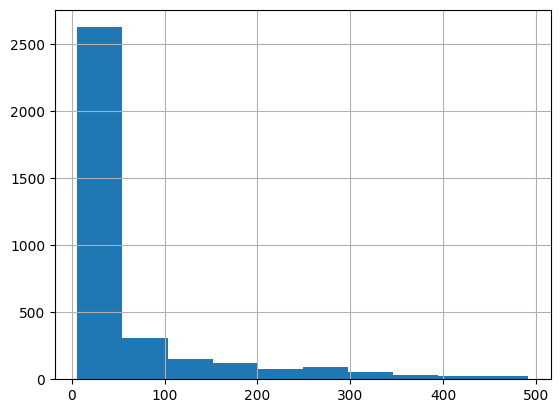

In [31]:
train_df,train_devices,test_device_ids, device_targets,devices_per_valid_domain = get_initial_train_data(db_df,**params["training_data"])


In [32]:
# preprocess timeseries
from functools import partial
def process_activity_timeseries(domain_df,bin_hours=6,gaussian_filter=True,n_days_each_side=3,std=1.5,drop_na=True,drop_zeros=False):
    activity_per_3h = domain_df["Device_ID"].resample(f'{str(bin_hours)}h').nunique()
    activity_per_3h.rename("Activity",inplace=True)
    gaussian_window_hours = int(n_days_each_side*24/bin_hours*2) # n_days_each_side * 24h / 3h_per_bin * 2 sides
    if gaussian_filter:
        activity_per_3h = activity_per_3h.rolling(window=gaussian_window_hours, win_type='gaussian',center=True,min_periods=1,closed="both").mean(std=std)
    if drop_na:
        activity_per_3h.dropna(inplace=True)
    if drop_zeros:
        activity_per_3h = activity_per_3h[activity_per_3h["Activity"]!=0]
    return activity_per_3h.round().astype(int).to_frame()

def get_domain_activity_timeseries(train_df,domain_ts_kwargs):
    process_domain_timeseries = partial(process_activity_timeseries,**domain_ts_kwargs)
    process_domain_timeseries.__name__ =process_activity_timeseries.__name__
    domain_timeseries = train_df[["Domain_Name","Target","Device_ID"]].groupby(["Domain_Name","Target"]).apply(process_domain_timeseries)
    
    domain_timeseries = domain_timeseries
    domain_timeseries["activity_fraction"] = domain_timeseries.groupby(["Domain_Name", "Target"]).transform(lambda x: x/x.sum())
    # Add the sum of activity as a new column
    domain_activity = domain_timeseries.groupby(["Domain_Name", "Target"])[["Activity"]].sum()

    domain_activity = domain_activity.rename(columns={"Activity": "target_domain_activity"})
    # Merge the results
    domain_timeseries = domain_timeseries.merge(domain_activity, left_index=True, right_index=True)
    # Reset index to get Target as a column, then pivot to get Target as columns
    pivot_fraction_ts = domain_timeseries.reset_index().pivot(
        index=['Datetime', 'Domain_Name'],
        columns='Target'
    ).fillna(0)
    pivot_fraction_ts.columns = [f'{col[0]}_{col[1]}' for col in pivot_fraction_ts.columns]
    return pivot_fraction_ts
def get_user_activity_timeseries(db_df,user_ts_kwargs):
    process_user_timeseries = partial(process_activity_timeseries,**user_ts_kwargs)
    process_user_timeseries.__name__ =process_activity_timeseries.__name__
    user_timeseries = db_df[["Domain_Name","Device_ID"]].groupby(["Domain_Name","Device_ID"]).apply(process_user_timeseries)
    # user_timeseries.index = mpd.MultiIndex.from_tuples(user_timeseries.index.to_list(),names=["Domain_Name","Device_ID","Datetime"])
    return user_timeseries

In [33]:
domain_activity_timeseries = get_domain_activity_timeseries(
    train_df, params["domain_activity_timeseries"])
user_activity_timeseries = get_user_activity_timeseries(
    db_df.loc[db_df["Domain_Name"].isin(devices_per_valid_domain.index)], params["user_activity_timeseries"])._repartition()


Falling back to a full-axis implementation.
Falling back to a TreeReduce implementation.


In [34]:
# from scipy import stats
import numpy as np

def class_probability_score(active, p_active_given_a, p_active_given_b, prior_a=0.5, total_users=100):
    """
    Calculate class probability score with vectorized operations
    
    Args:
        active: Boolean indicating if user was active
        p_active_given_a: Probability of activity given class A (0)
        p_active_given_b: Probability of activity given class B (1)
        prior_a: Prior probability for class A
        total_users: Total number of users for confidence calculation
    """
    # Use numpy for vectorized operations
    likelihood_a = np.where(active, p_active_given_a, 1 - p_active_given_a)
    likelihood_b = np.where(active, p_active_given_b, 1 - p_active_given_b)
    
    # Avoid division by zero
    evidence = (likelihood_a * prior_a + likelihood_b * (1 - prior_a))
    posterior_a = (likelihood_a * prior_a) / evidence

    return posterior_a #* confidence_factor

def get_user_domain_scores(domain_activity_timeseries,user_activity_timeseries):
    merged_timeseries_df = domain_activity_timeseries.reset_index().merge(
        user_activity_timeseries.reset_index(), how="left", on=["Domain_Name", "Datetime"]
    ).set_index(["Datetime", "Domain_Name", "Device_ID"])

    merged_timeseries_df["bin_activity"] = merged_timeseries_df["Activity_0"]+merged_timeseries_df["Activity_1"]
    merged_timeseries_df["total_activity"] = (merged_timeseries_df["target_domain_activity_0"]+merged_timeseries_df["target_domain_activity_1"])
    merged_timeseries_df["relative_0_activity"] = merged_timeseries_df["target_domain_activity_0"]/merged_timeseries_df["total_activity"]
    merged_timeseries_df["score"]=class_probability_score(merged_timeseries_df["Activity"], merged_timeseries_df["activity_fraction_0"], merged_timeseries_df["activity_fraction_1"], prior_a=merged_timeseries_df["relative_0_activity"], total_users=merged_timeseries_df["bin_activity"])
    merged_timeseries_df["weighted_score"] = (merged_timeseries_df["score"])*(merged_timeseries_df["bin_activity"])#np.log(1+merged_df["bin_activity"]).astype(int))
    final_scores = merged_timeseries_df.groupby(["Device_ID","Domain_Name"])["weighted_score"].mean()
    final_scores_pivot = final_scores.to_frame().reset_index().pivot(index="Device_ID",columns="Domain_Name").fillna(0)

    final_scores_pivot=(final_scores_pivot-final_scores_pivot.values.min())/(final_scores_pivot.values.max()-final_scores_pivot.values.min())*2-1
    return final_scores_pivot

In [35]:
final_scores_pivot = get_user_domain_scores(domain_activity_timeseries,user_activity_timeseries)

Falling back to a TreeReduce implementation.
Falling back to a TreeReduce implementation.


In [36]:
# baseline features
def get_active_days_per_user(user_domain_ts):
    """
    Calculate the number of unique days each user had any activity.

    Args:
        user_domain_ts: MultiIndex Series with levels [Domain_Name, Device_ID, Datetime]

    Returns:
        Series with index Device_ID and values being number of unique active days
    """
    # Reset index to get Datetime as a column
    user_domain_ts = user_domain_ts.reset_index()

    # Convert Datetime to date (removing time component)
    user_domain_ts['Date'] = user_domain_ts['Datetime'].dt.date

    # Group by Device_ID and count unique dates where Activity > 0
    active_days = user_domain_ts[user_domain_ts['Activity'] > 0].groupby('Device_ID')['Date'].nunique()

    active_days = active_days.astype(int)
    active_days.name = "Active_Days"
    active_days = (active_days-active_days.min()
                   ) / (active_days.max()-active_days.min())*2-1
    return active_days


def get_activity_per_time_bin(df, bin_hours=3):
    # Convert datetime to time only
    # time_index = db_df.index.to_series().dt.time
    # df["time"] = time_index
    df_copy = df.copy()
    df_copy["time"] = db_df.index.to_series().dt.hour.astype(int)//bin_hours
    df_copy["day_part_activity"] = 0
    activity_per_time_range = df_copy[["Device_ID", "time", "day_part_activity"]].groupby(
        ["Device_ID", "time"]).count()
    activity_per_time_range["activity_fraction"] = activity_per_time_range.groupby("Device_ID").apply(lambda x: x/x.sum()).values
    activity_per_time_range = activity_per_time_range[["activity_fraction"]].reset_index()
    activity_per_time_range = activity_per_time_range.pivot(index="Device_ID",columns="time",values="activity_fraction")
    activity_per_time_range.columns = [f"time_{col}" for col in activity_per_time_range.columns]
    activity_per_time_range = (activity_per_time_range-activity_per_time_range.stack().min())/(activity_per_time_range.stack().max()-activity_per_time_range.stack().min())*2-1
    activity_per_time_range = activity_per_time_range.fillna(0)
    return activity_per_time_range  # .round().astype(int)

In [39]:
active_days = get_active_days_per_user(user_activity_timeseries)
del user_activity_timeseries
activity_per_time_range = get_activity_per_time_bin(db_df)


In [41]:
final_features = device_targets.set_index("Device_ID").join(final_scores_pivot)
if active_days is not None:
    final_features = final_features.join(active_days,how="left")
if activity_per_time_range is not None:
    final_features = final_features.join(activity_per_time_range,how="left")
final_features = final_features.fillna(0)
final_features.columns = [str(col) for col in final_features.columns]

In [42]:
import xgboost
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score
def prepare_model_data(final_features,train_devices,test_device_ids):
    X_train = final_features[final_features.index.isin(train_devices)].drop('Target', axis=1)
    y_train = final_features[final_features.index.isin(train_devices)]['Target']

    X_test = final_features.loc[final_features.index.isin(test_device_ids)]
    y_test = final_features[final_features.index.isin(test_device_ids)]['Target']
    return X_train,y_train,X_test,y_test

def train_model(X_train,y_train,X_test,y_test,params):
    xgb_reg = xgboost.XGBRegressor(random_state=0, subsample=0.8, colsample_bytree=0.8, learning_rate= 0.1,
                               n_estimators= 150, max_depth=6, objective ='binary:logistic' ,eval_metric =roc_auc_score)
    selector = RFE(xgb_reg, n_features_to_select=1000, step=20000)
    selector = selector.fit(X_train, y_train)
    best_features = list(X_train.columns[selector.support_])
    test_prediction = selector.estimator_.predict(X_test[best_features])
    test_auc =round(roc_auc_score(y_test,test_prediction), 3)
    return test_auc,selector, best_features


In [43]:
final_features

,Target,381,2147,2209,2284,3083,3171,3379,3852,3930,...,2408371,Active_Days,time_0,time_1,time_2,time_3,time_4,time_5,time_6,time_7
Device_ID,,,,,,,,,,,,,,,,,,,,,
124,0,-1.0,-1.00000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-0.978559,...,-1.000000,1.000000,-0.958315,-0.921484,-0.390844,-0.548318,-0.334510,-0.556728,-0.628650,-0.957590
148,1,-1.0,-1.00000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,-1.000000,0.500000,-0.909242,-0.997947,-0.921615,-0.543730,-0.528421,-0.497700,-0.284117,-0.613666
174,0,-1.0,-1.00000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,-1.000000,1.000000,-0.291885,-0.802576,-0.848626,-0.811361,-0.747573,-0.497683,-0.707230,-0.589504
242,0,-1.0,-1.00000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,-1.000000,1.000000,-0.801475,-0.941976,-0.818510,-0.769759,-0.732894,-0.554049,-0.400018,-0.277757
266,1,-1.0,-1.00000,-0.978559,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,-1.000000,0.833333,-0.967316,-0.990827,-0.720538,-0.352409,-0.355516,-0.642756,-0.595665,-0.671411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69734,1,-1.0,-1.00000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-0.984127,...,-1.000000,0.833333,-0.901509,-0.952518,-0.727713,-0.394354,-0.385991,-0.511381,-0.636938,-0.786033
69811,0,-1.0,-0.98928,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,-1.000000,1.000000,-0.759236,-0.727661,-0.634964,-0.601684,-0.578957,-0.602009,-0.665160,-0.726768
69891,1,-1.0,-1.00000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,-1.000000,0.500000,-0.899392,-0.944482,-0.751072,-0.326923,-0.683007,-0.580018,-0.481458,-0.630087


In [ ]:
X_train,y_train,X_test,y_test = prepare_model_data(final_features,train_devices,test_device_ids)
score,selector,best_features = train_model(X_train,y_train,X_test,y_test,params["model"])
print(f'The auc for validation set: {score}')
run["metrics/roc_auc"] = score
run["metrics/selected_features"] = best_features
run["metrics/feature_importances"] = selector.estimator_.feature_importances_
run["metrics/feature_ranking"] = selector.ranking_
run["metrics/feature_support"] = selector.support_
# Close the run
run.stop()

In [23]:
# manual feature filter
# Create function to filter features based on mean values
# def filter_low_mean_features(features_df, percentile=0.1):
#     # Calculate absolute mean values for each feature
#     abs_means = abs(features_df).mean()
    
#     # Calculate percentile threshold of absolute means
#     threshold = abs_means.quantile(percentile)
    
#     # Get features with absolute means above threshold
#     significant_features = abs_means[abs_means >= threshold].index
    
#     # Filter features

#     return significant_features

# Apply the filtering function
